
## Model input 

In [ ]:
import os
import netCDF4

# Define the model
model = 'CNRM'

# Define directory and file name
directory = r'C:\Users\lache\Desktop\Cornell\Internship\Python Project' #CHANGE FOR WHERE FILE IS LOCATED
file_name = 'WavePnts_CNRM_ak_4m_Fut.nc'

# Dynamically create the full path
file_path = os.path.join(directory, file_name)

# Load the netCDF dataset
nc = netCDF4.Dataset(file_path)

In [3]:
ds=xr.open_dataset(xr.backends.NetCDF4DataStore(nc))
ds

<xarray.Dataset> Size: 9GB
Dimensions:        (time: 271752, station: 1139)
Coordinates:
  * time           (time) datetime64[ns] 2MB 2020-01-01 ... 2050-12-31T23:00:00
  * station        (station) float64 9kB 1.0 2.0 3.0 ... 1.684e+03 1.685e+03
Data variables:
    hs             (time, station) float32 1GB ...
    fp             (time, station) float32 1GB ...
    tr             (time, station) float32 1GB ...
    th1m           (time, station) float32 1GB ...
    th1p           (time, station) float32 1GB ...
    sth1m          (time, station) float32 1GB ...
    sth1p          (time, station) float32 1GB ...
    longitude      (station) float32 5kB ...
    latitude       (station) float32 5kB ...
    Station_Depth  (station) float32 5kB ...
Attributes: (12/13)
    product_name:     CMIP6 WW3 Extracted Station Wave Parameters
    area:             Alaskan 4 min wave grid
    data_type:        OCO spectra 2D
    format_version:   1.1
    CMIP6_Mod:        CNRM
    start_date:       2020-01-01
    ...               ...
    Temporal_Res:     hourly
    Extracted_Dir:    /caldera/projects/usgs/water/nywsc/lherdman/WW4/WW3-6.07.1
    Extracted_Files:  cnrm.pnts.ak_4m2020_tab.nc
    author:           USGS, lerikson@usgs.gov
    CMIP6_Winds:      CNRM-CM6-1-HR-r1i1p1f2, 3-hourly, 100 km resolution
    CMIP6_SeaIce:     CNRM-CM6-1-HR-r1i1p1f2, daily, 25 km resolution

<>:63: SyntaxWarning: invalid escape sequence '\c'
<>:64: SyntaxWarning: invalid escape sequence '\c'
<>:94: SyntaxWarning: invalid escape sequence '\c'
<>:95: SyntaxWarning: invalid escape sequence '\c'
<>:63: SyntaxWarning: invalid escape sequence '\c'
<>:64: SyntaxWarning: invalid escape sequence '\c'
<>:94: SyntaxWarning: invalid escape sequence '\c'
<>:95: SyntaxWarning: invalid escape sequence '\c'
C:\Users\lache\AppData\Local\Temp\ipykernel_8908\1378389178.py:63: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel('Latitude [$^\circ$North]')
C:\Users\lache\AppData\Local\Temp\ipykernel_8908\1378389178.py:64: SyntaxWarning: invalid escape sequence '\c'
  plt.xlabel('Longitude [$^\circ$East]')
C:\Users\lache\AppData\Local\Temp\ipykernel_8908\1378389178.py:94: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel('Latitude [$^\circ$North]')
C:\Users\lache\AppData\Local\Temp\ipykernel_8908\1378389178.py:95: SyntaxWarning: invalid escape sequence '\c'
  plt.xlabel('Longitude [

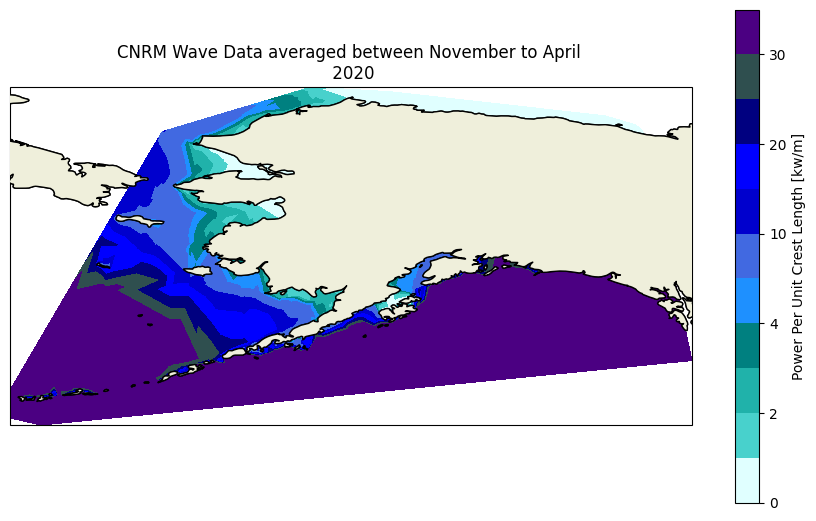

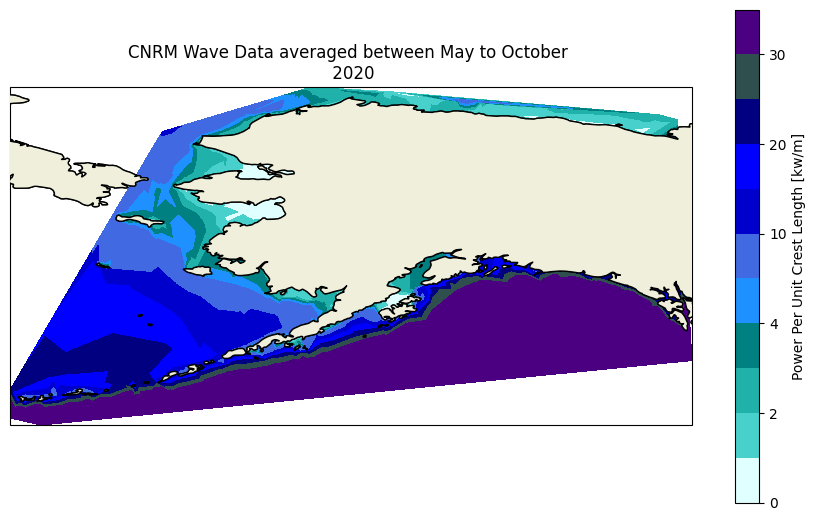

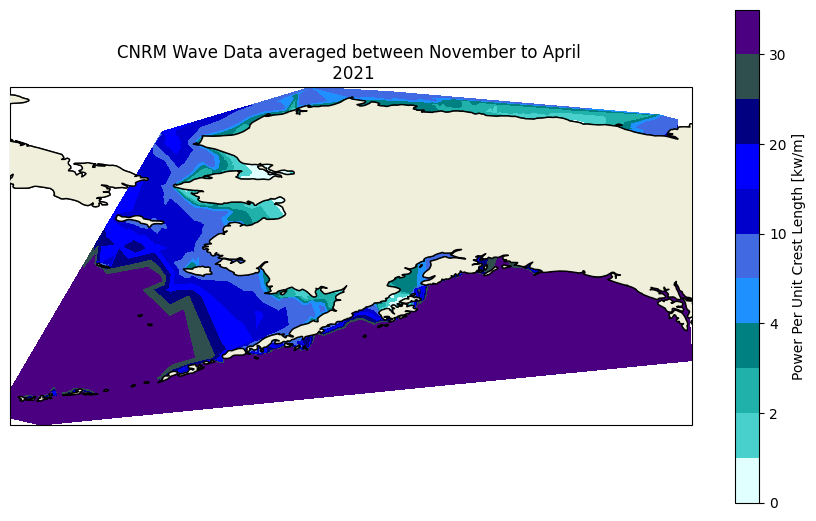

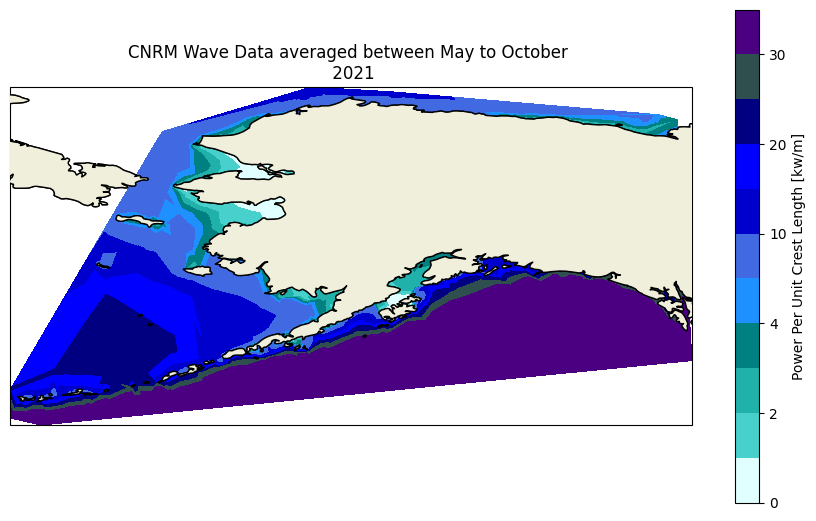

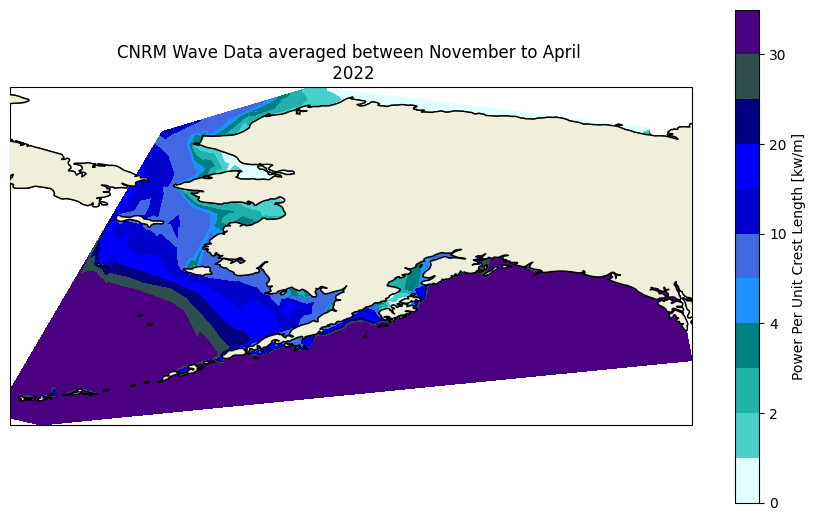

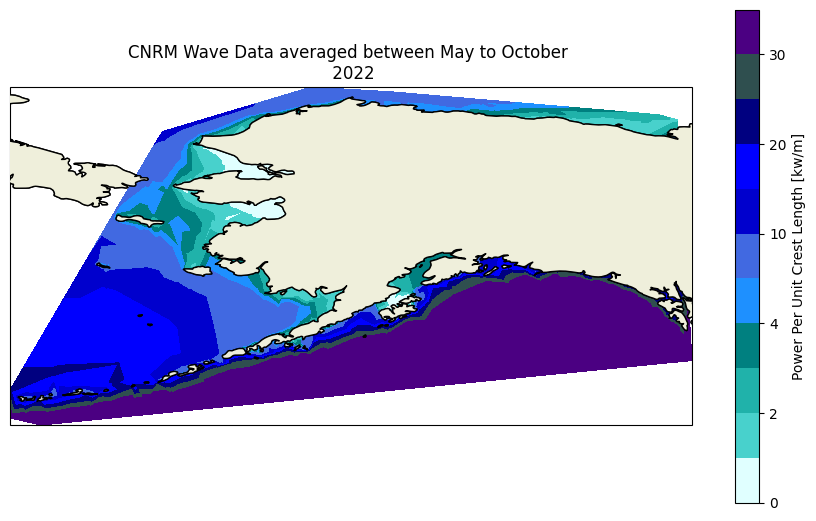

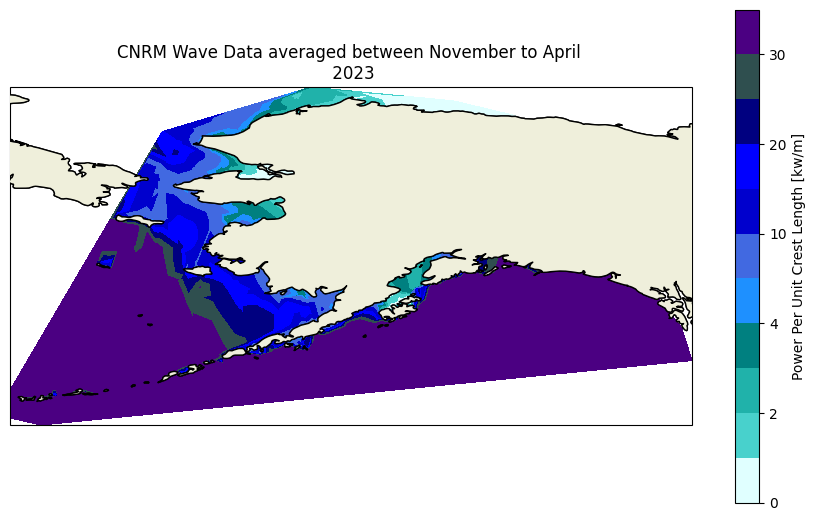

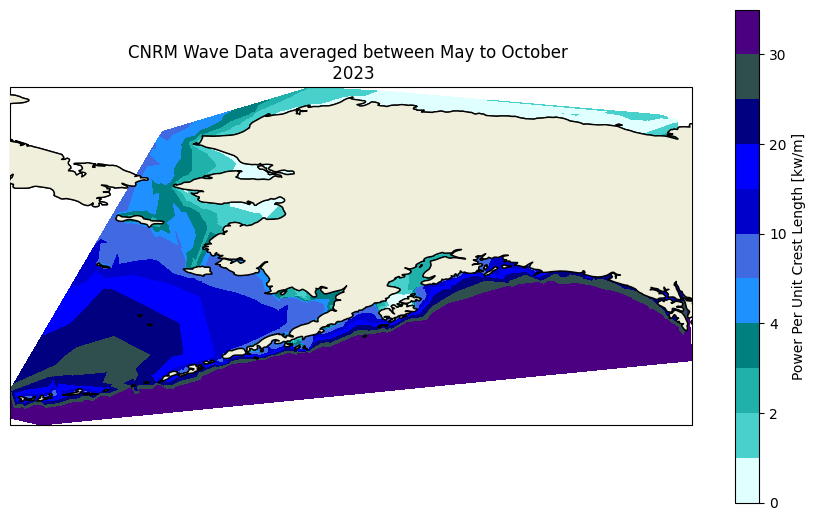

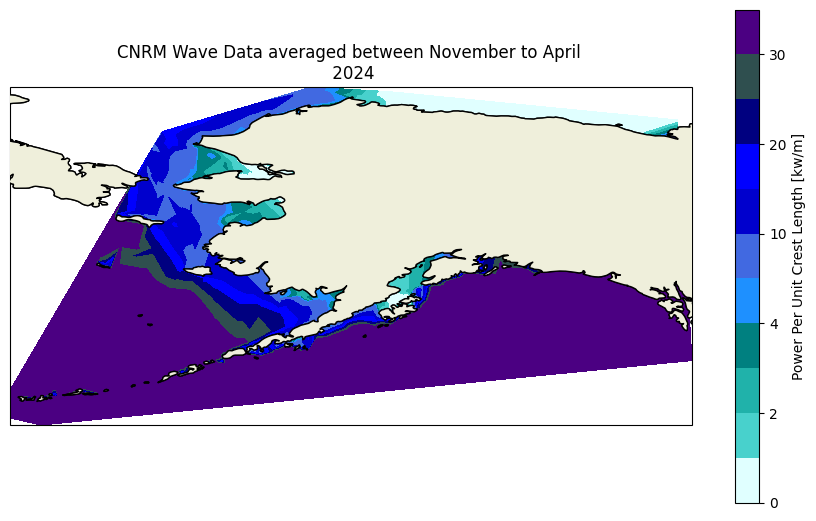

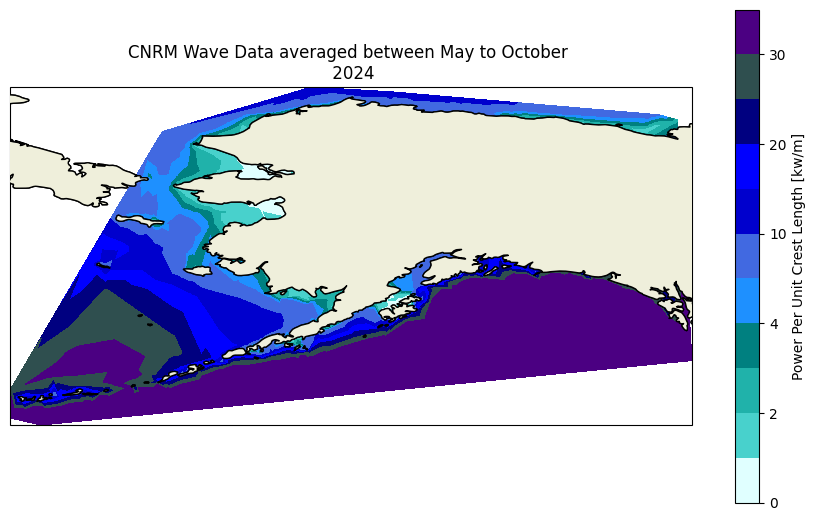

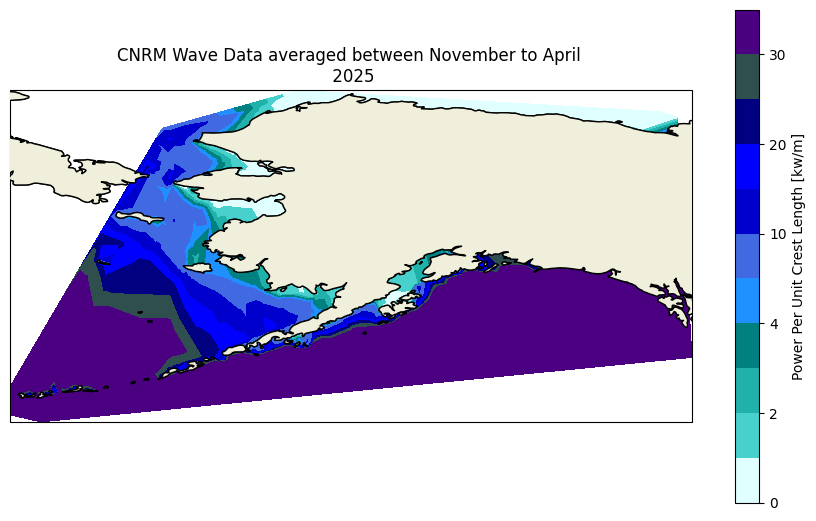

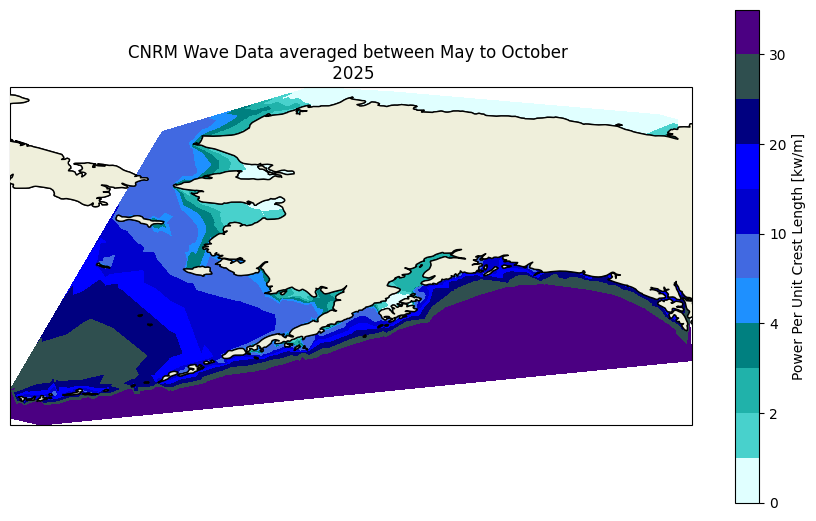

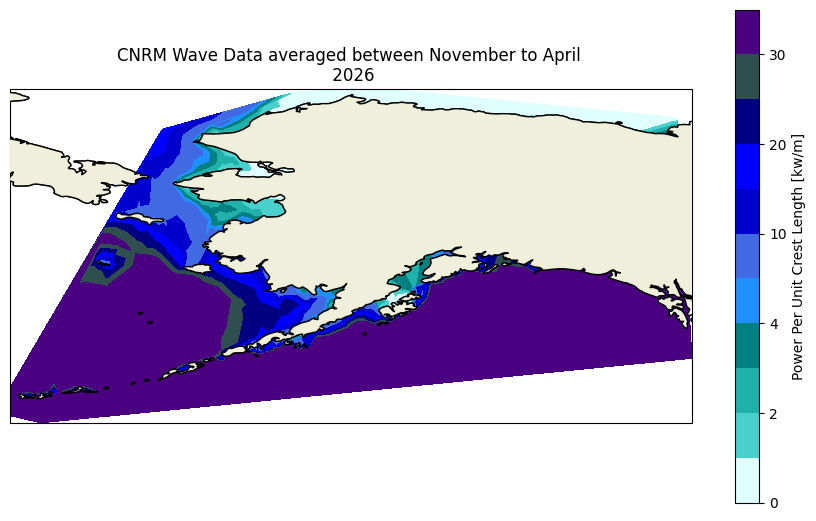

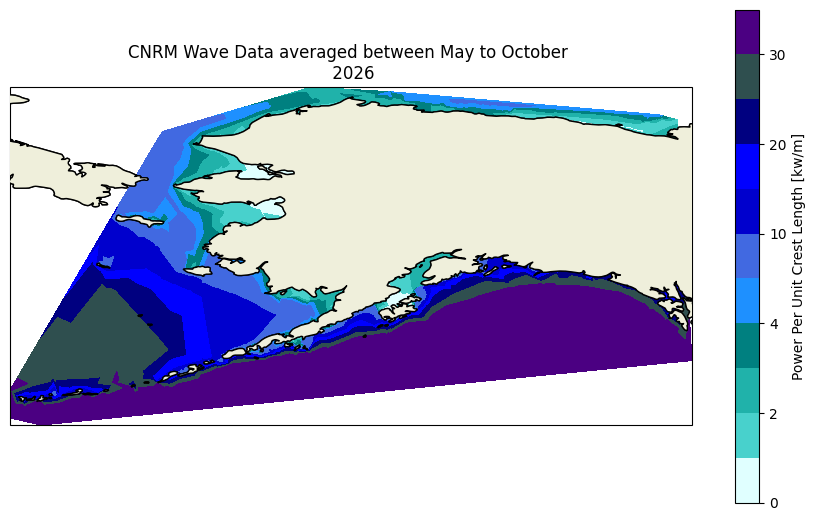

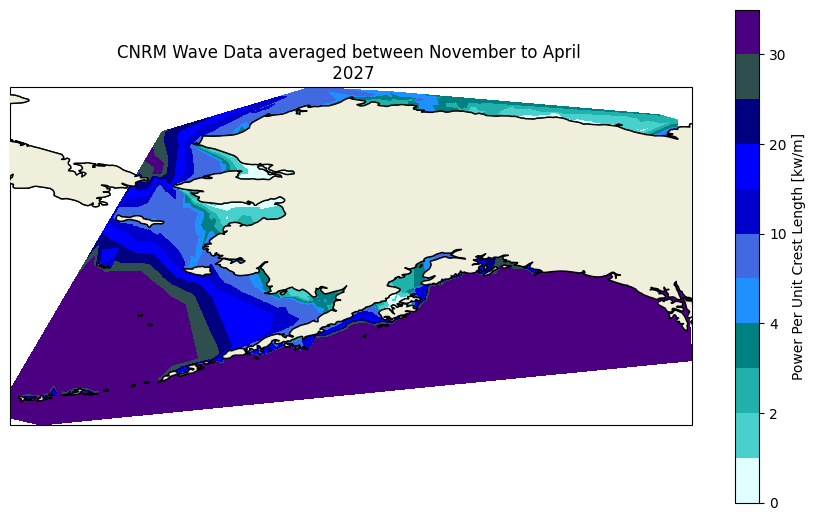

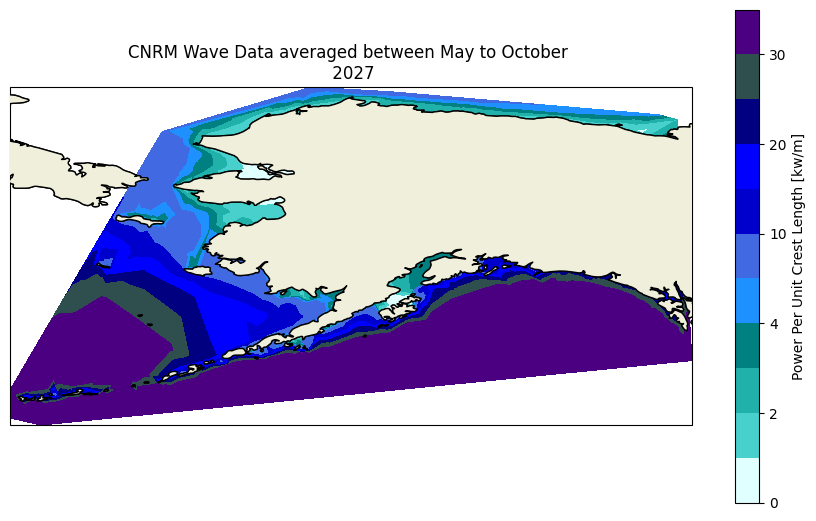

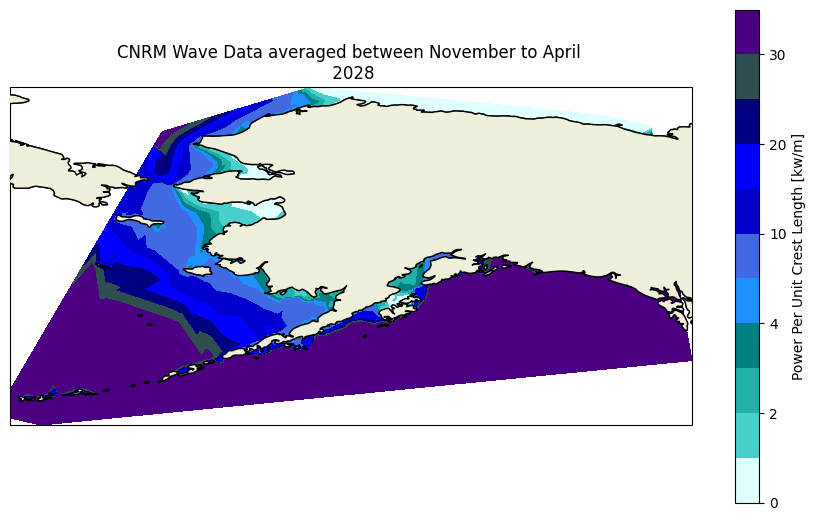

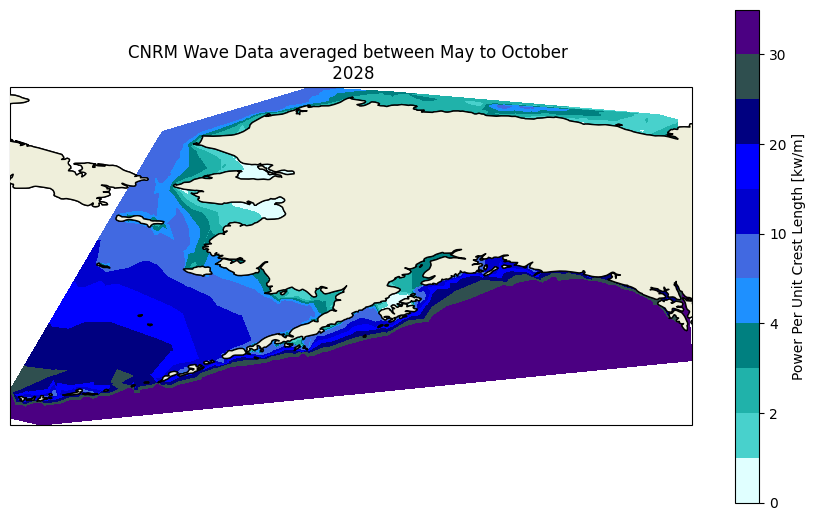

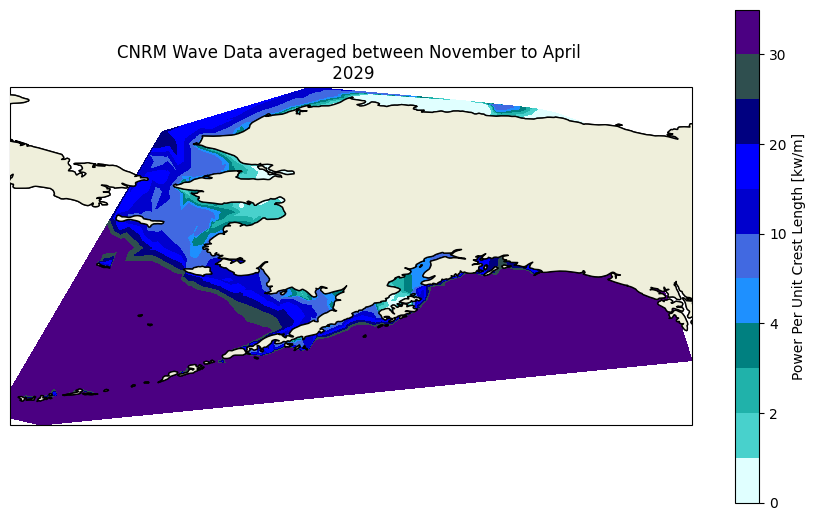

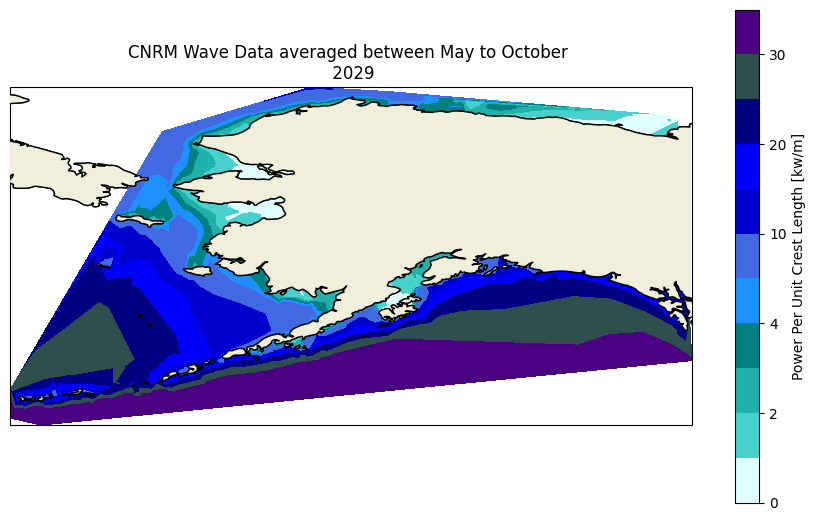

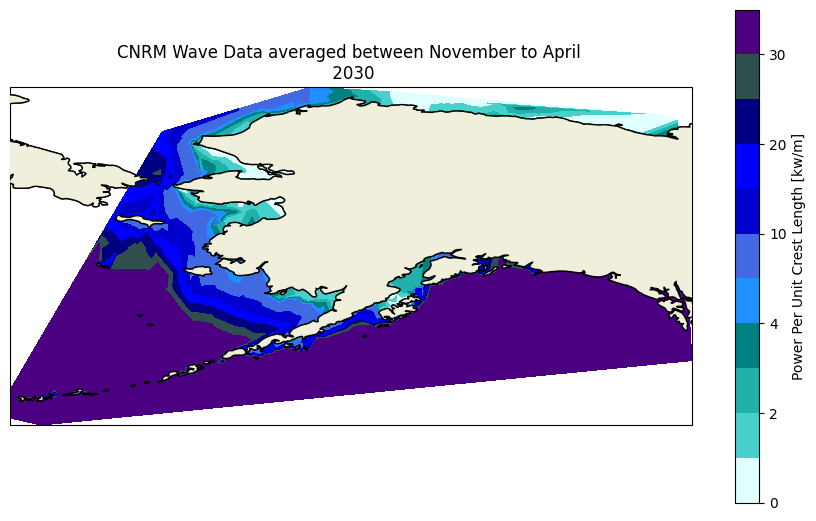

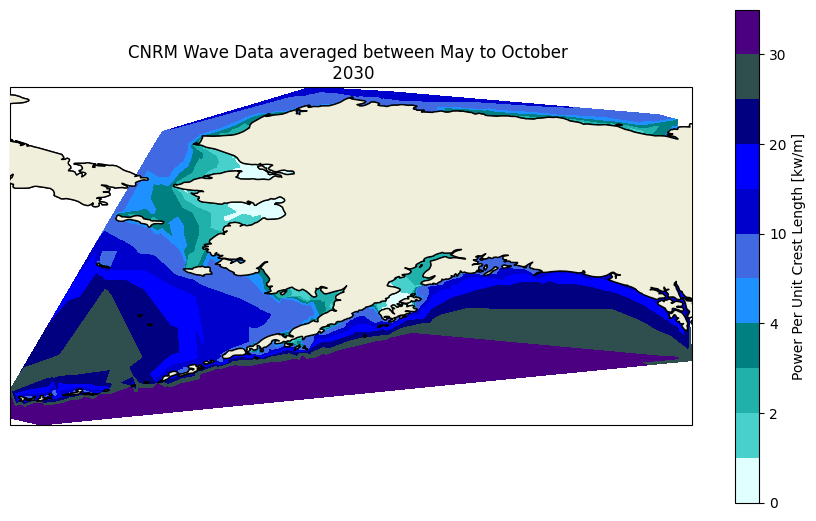

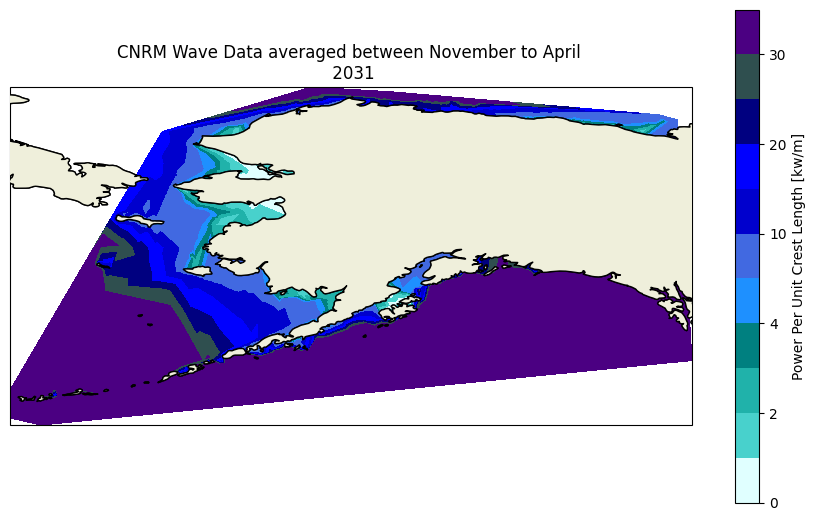

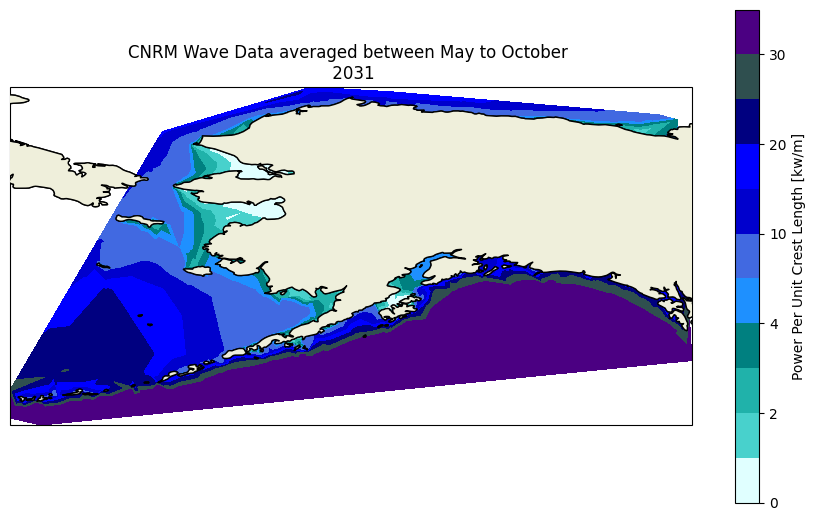

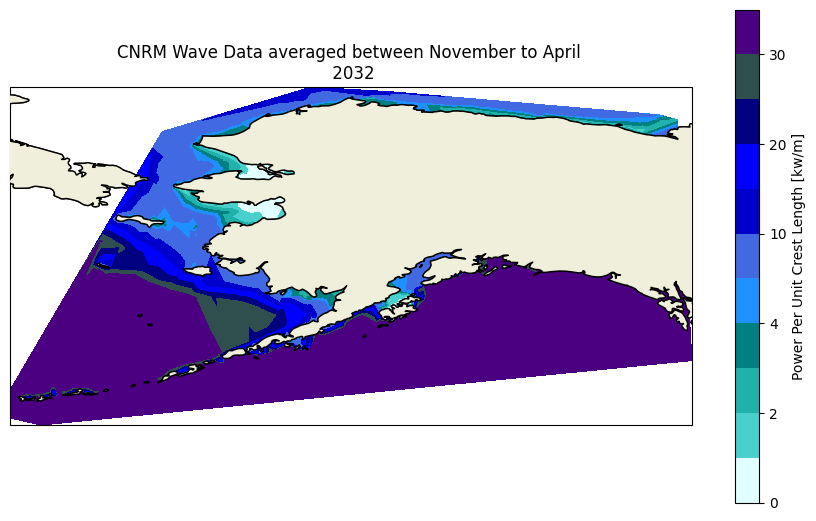

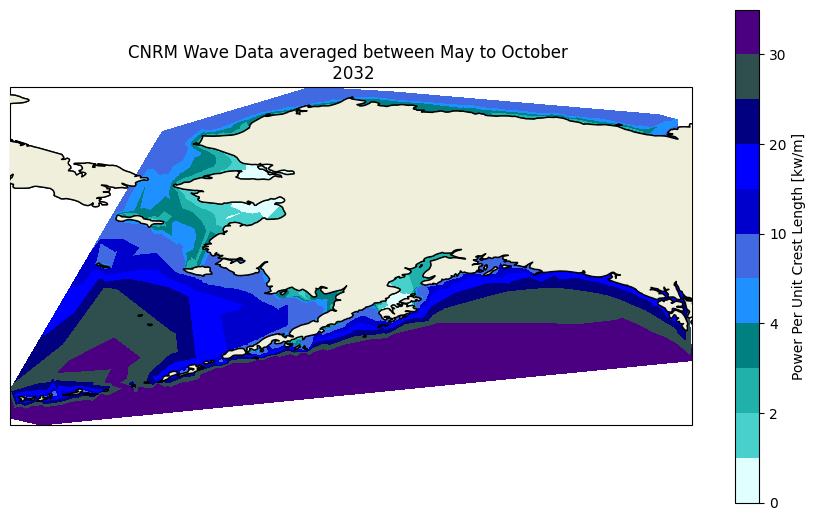

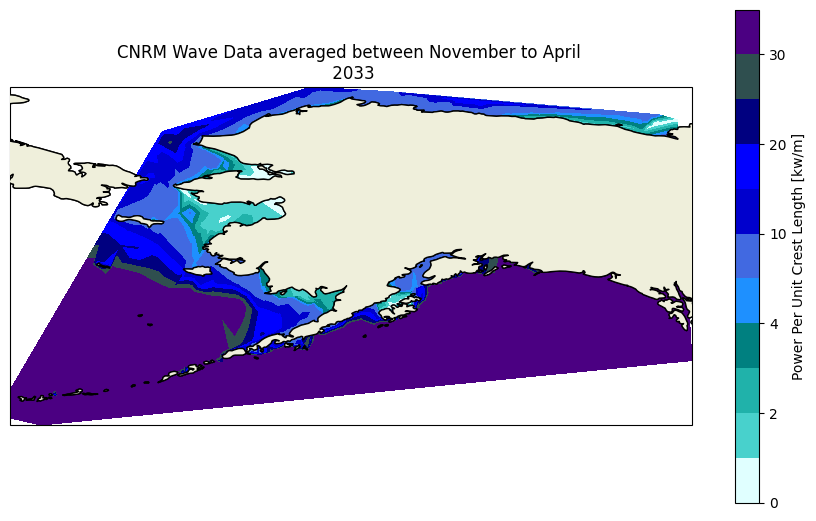

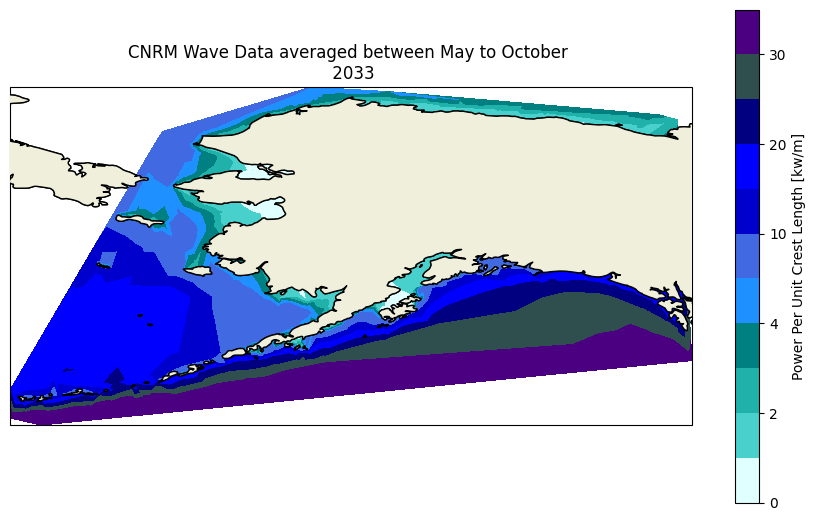

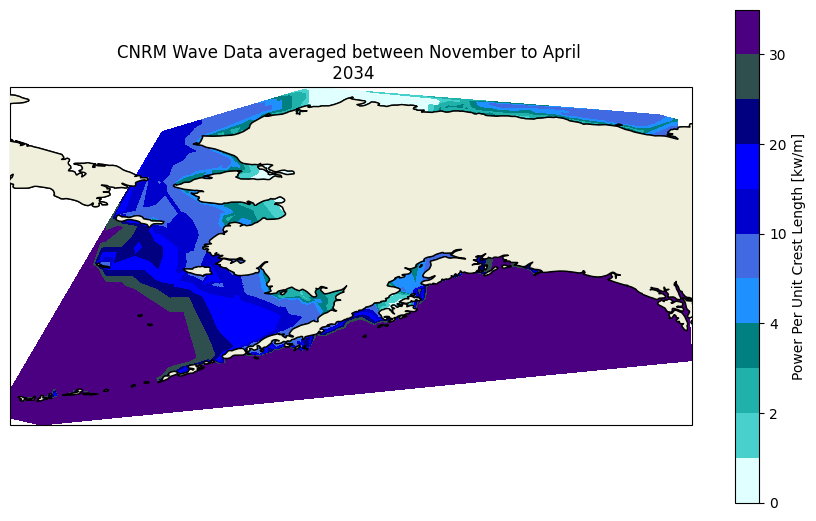

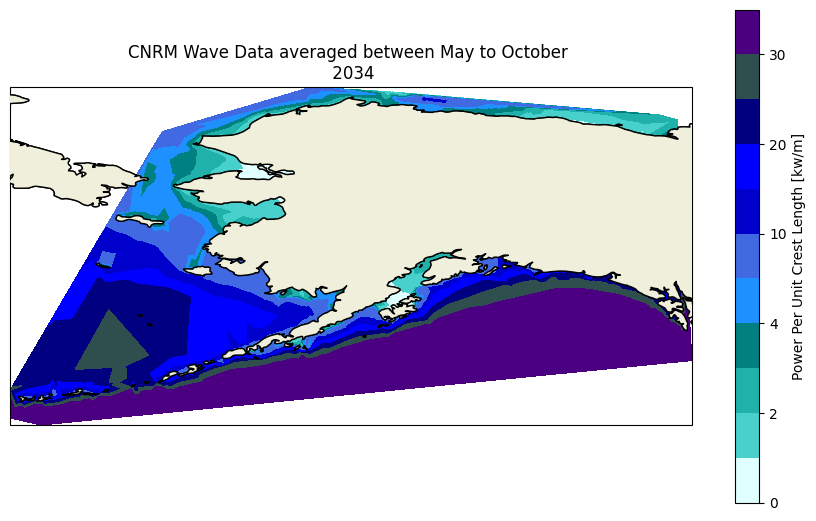

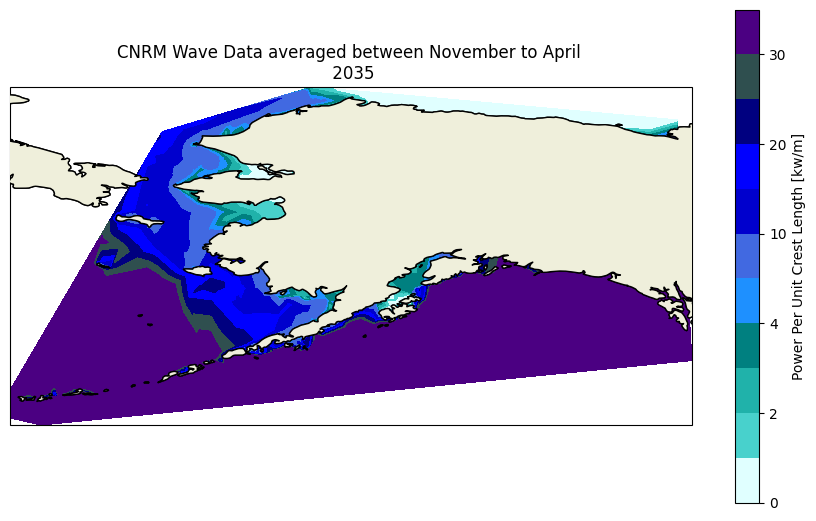

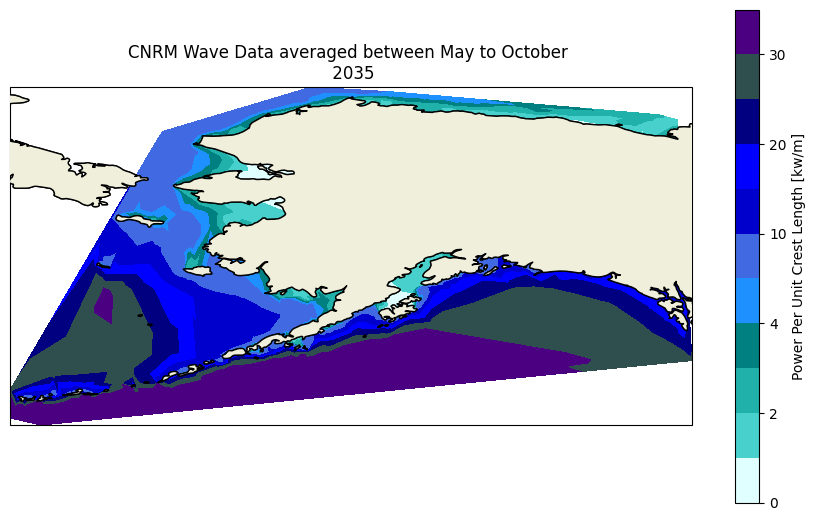

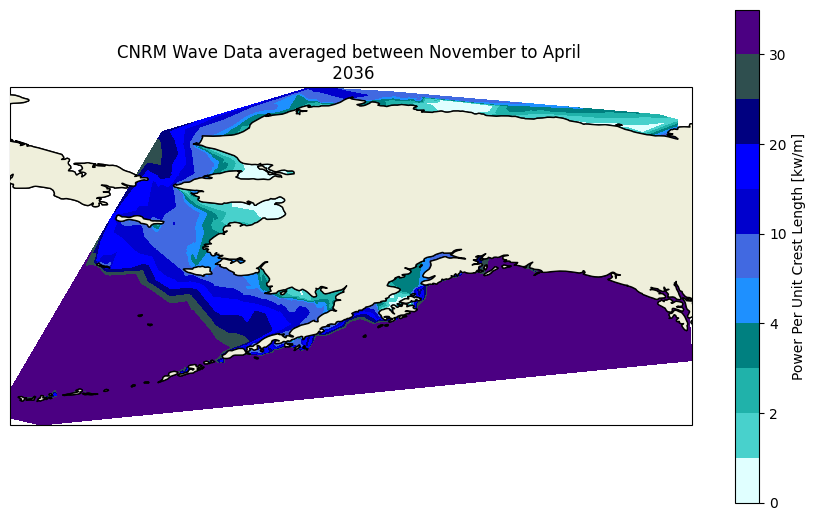

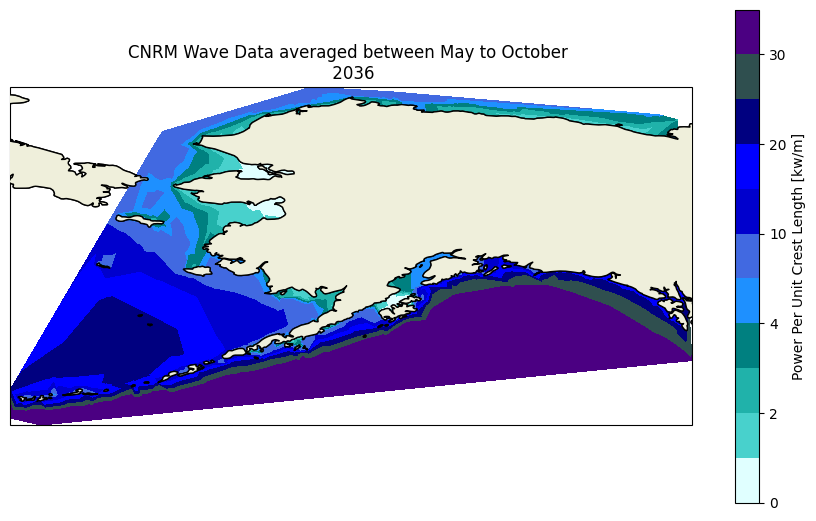

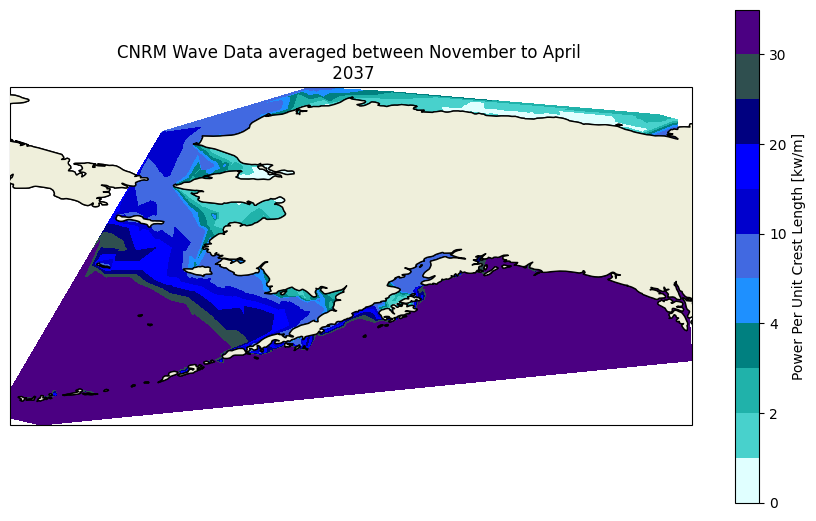

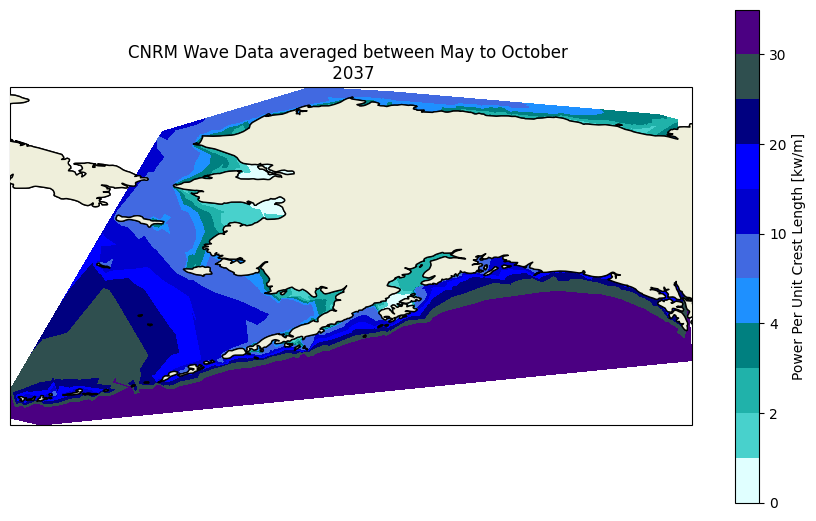

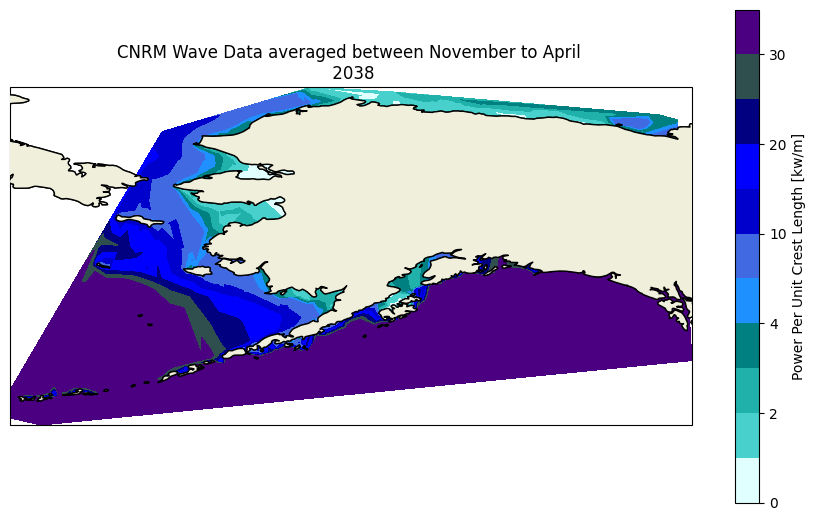

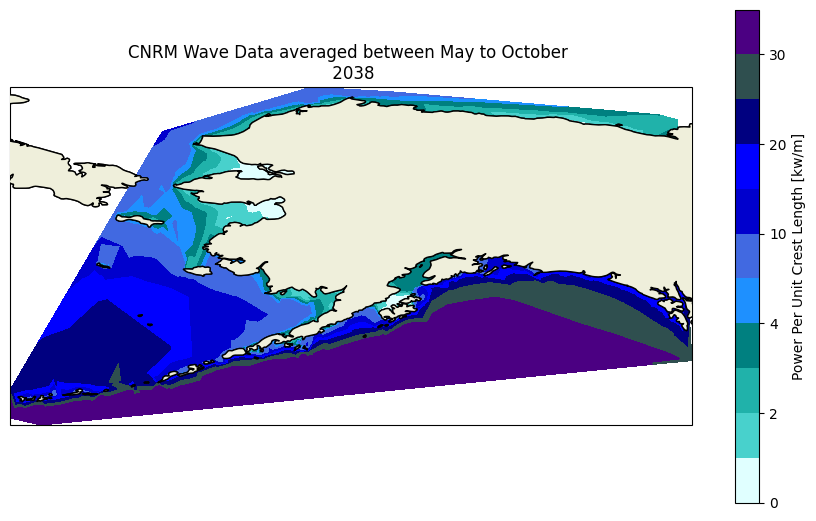

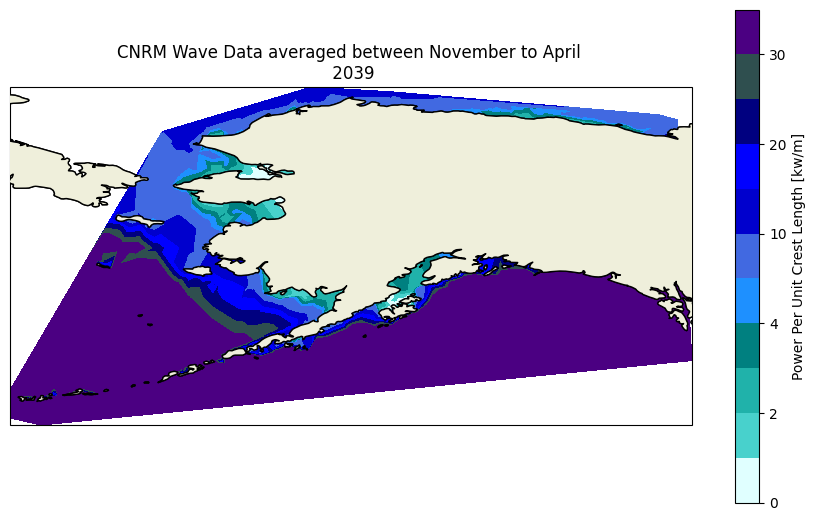

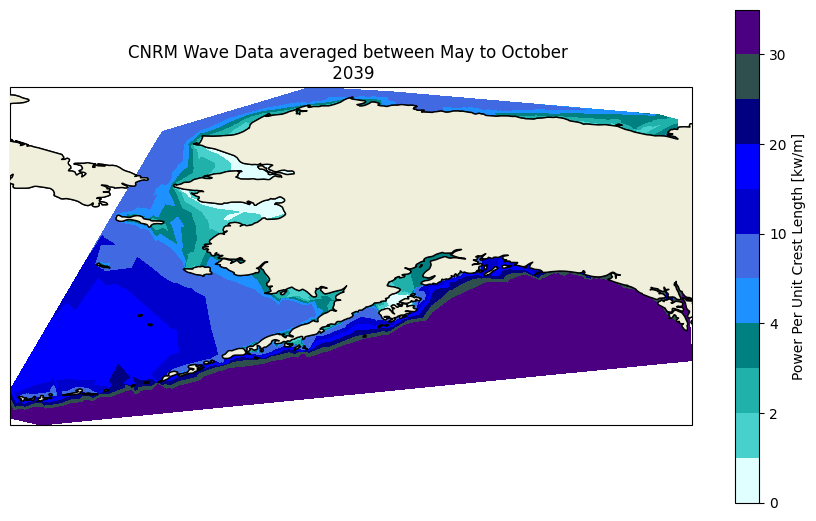

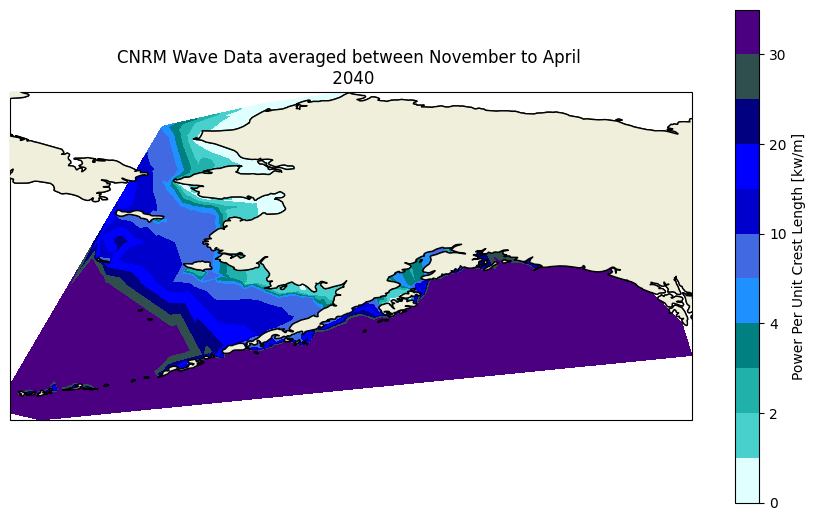

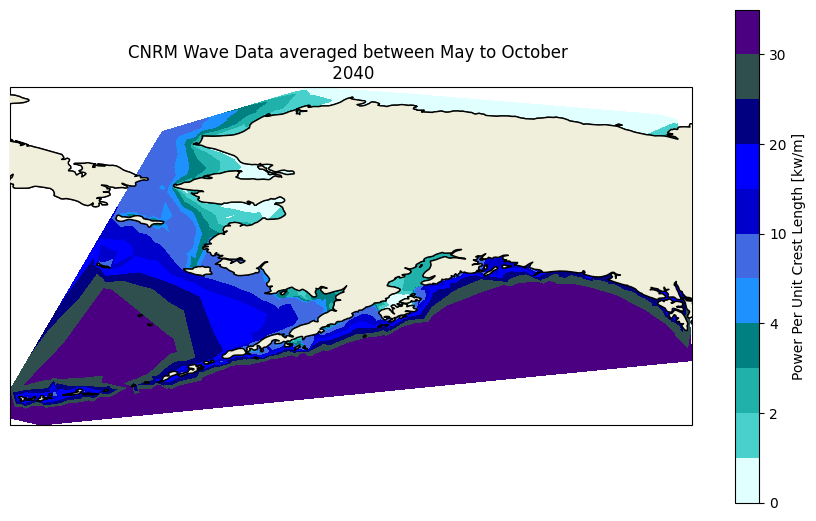

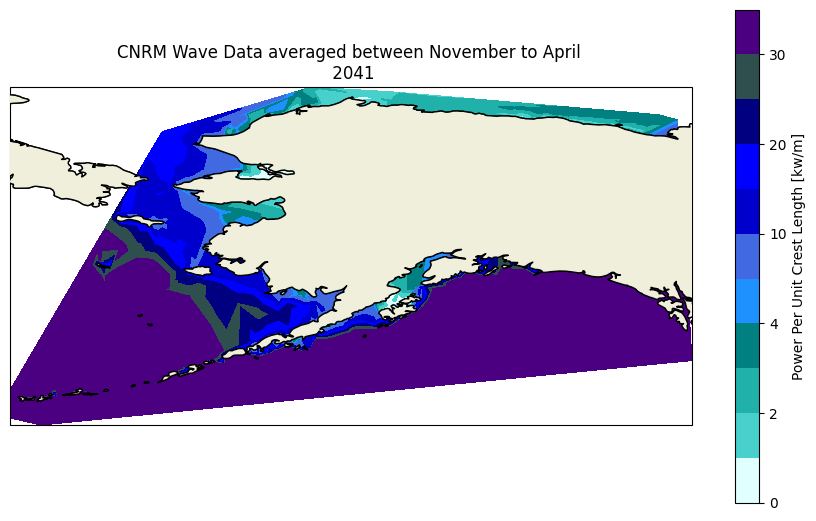

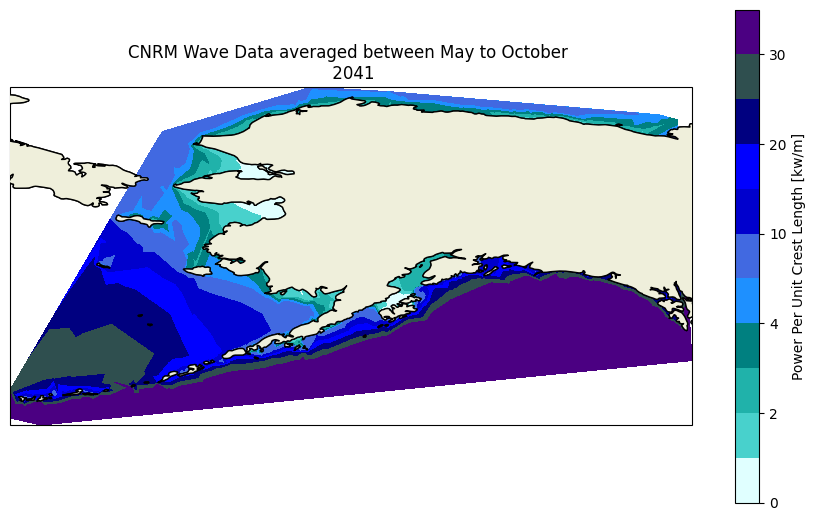

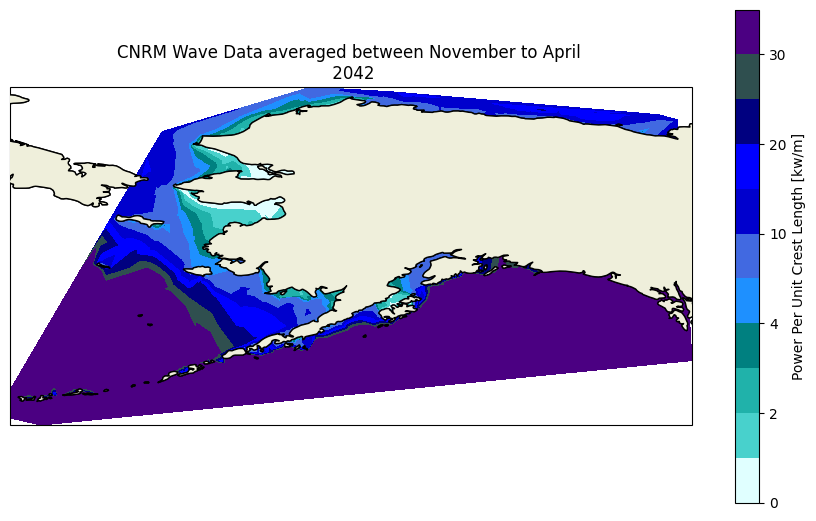

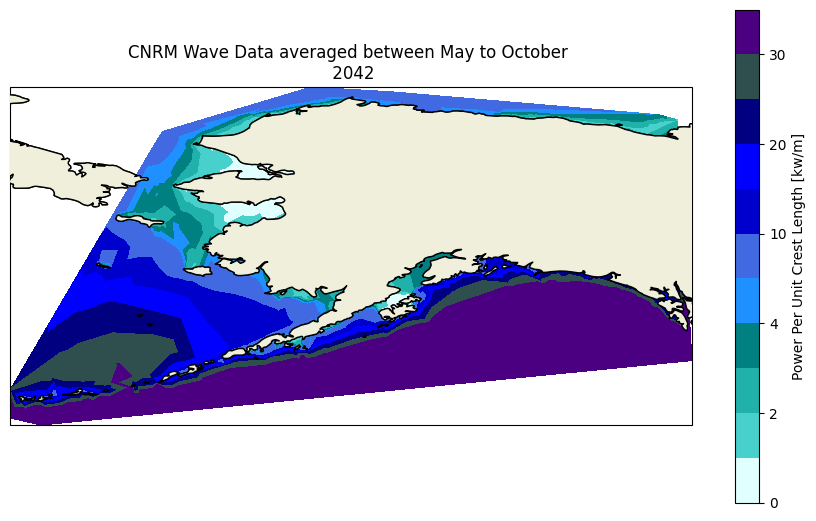

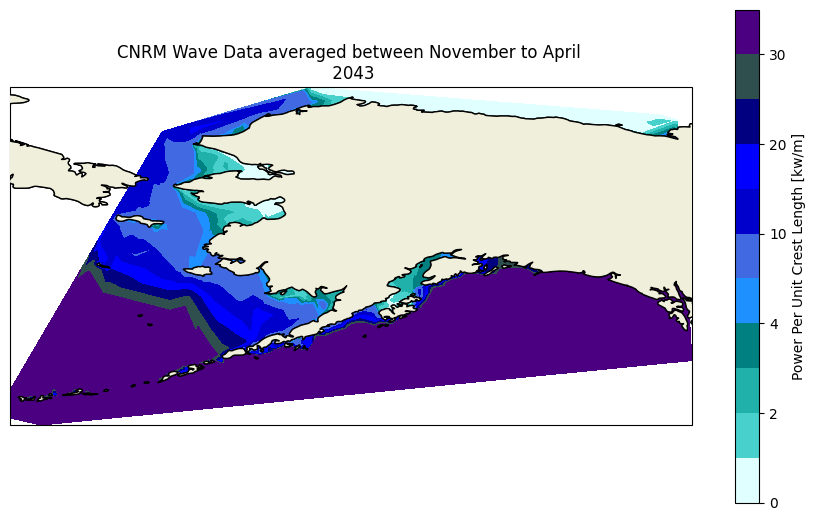

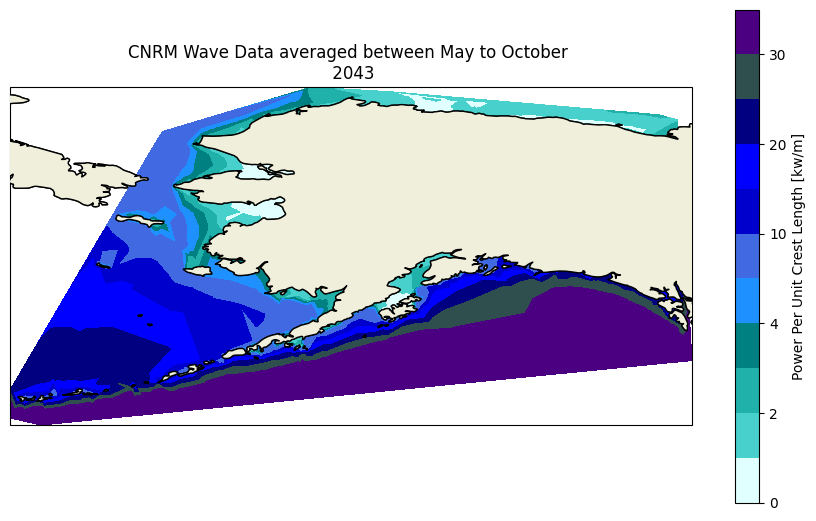

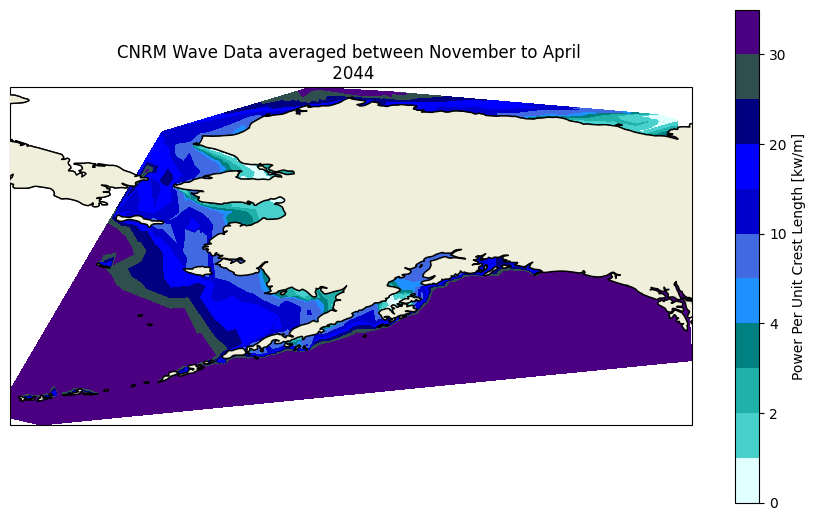

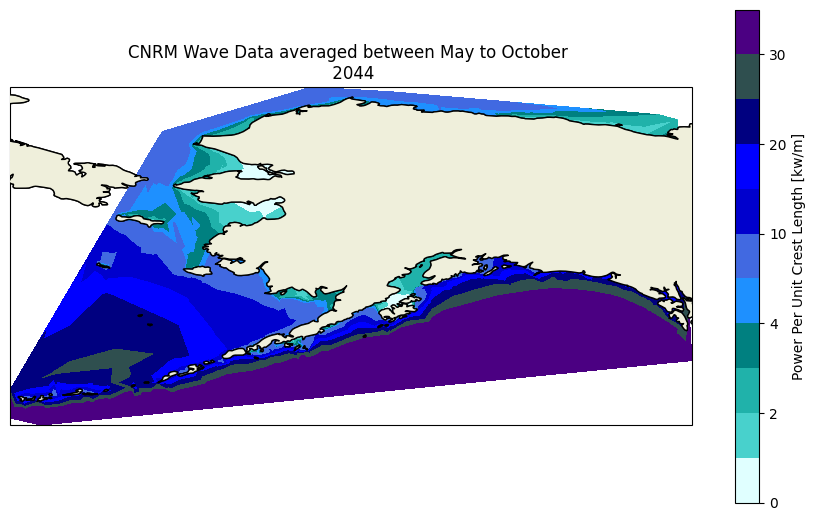

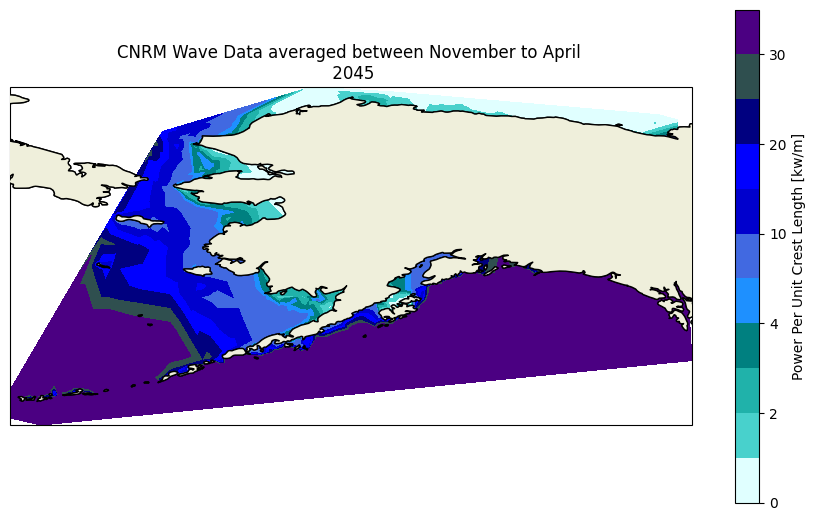

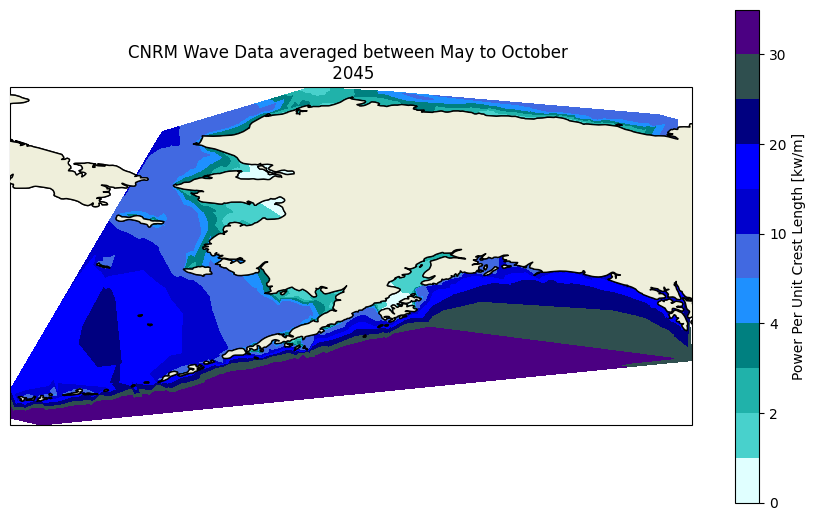

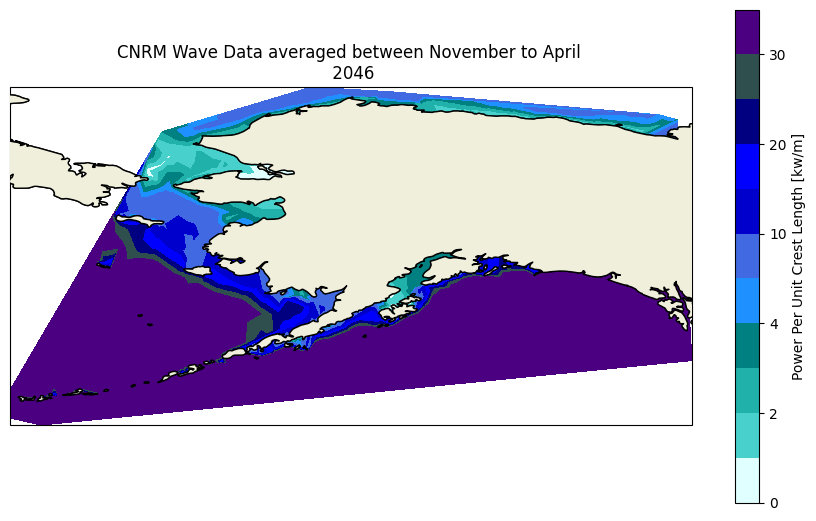

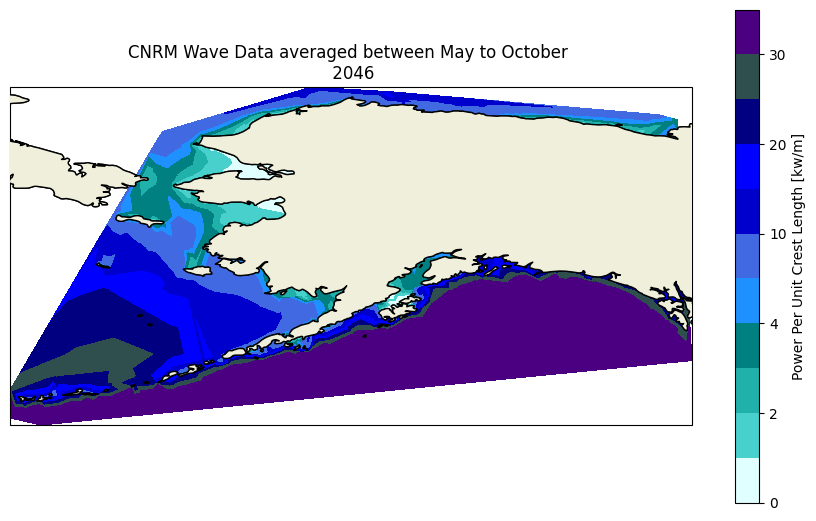

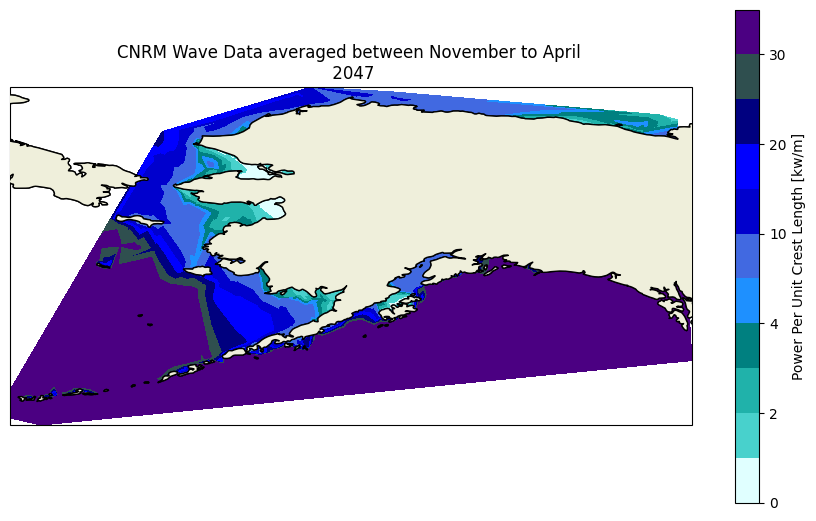

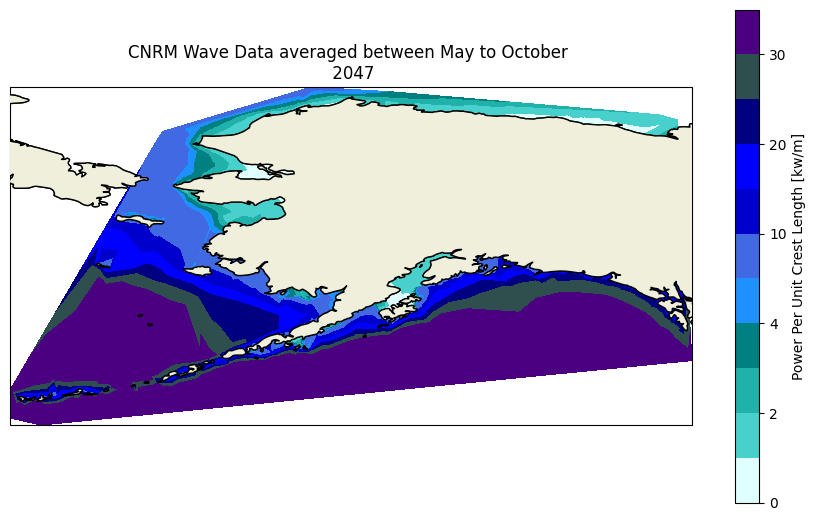

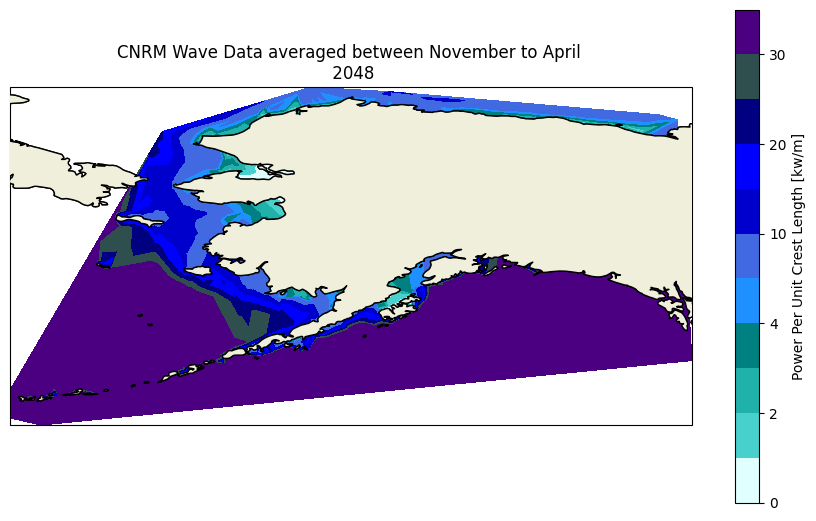

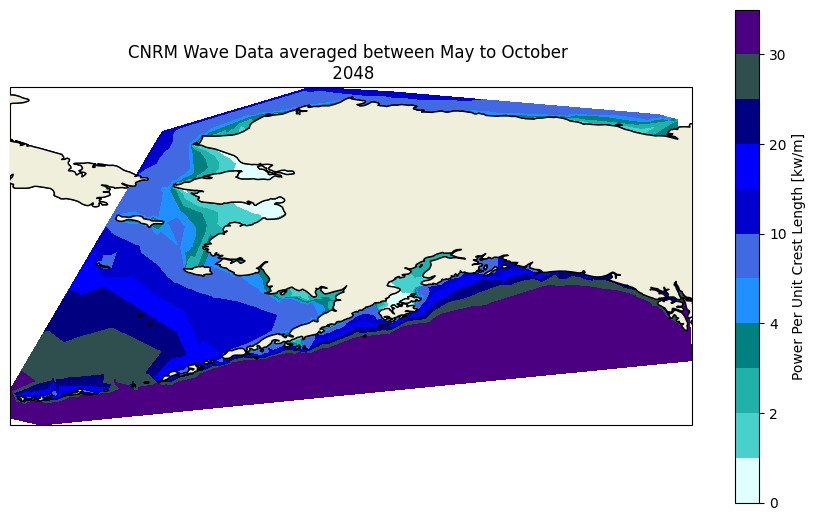

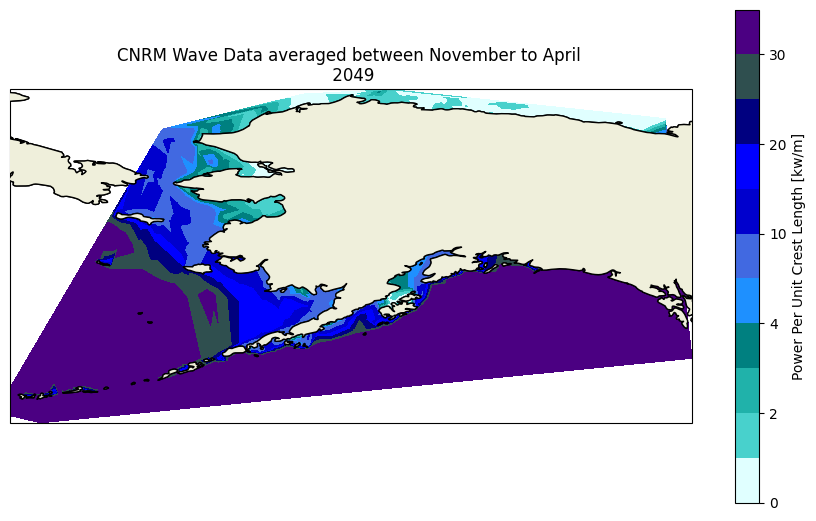

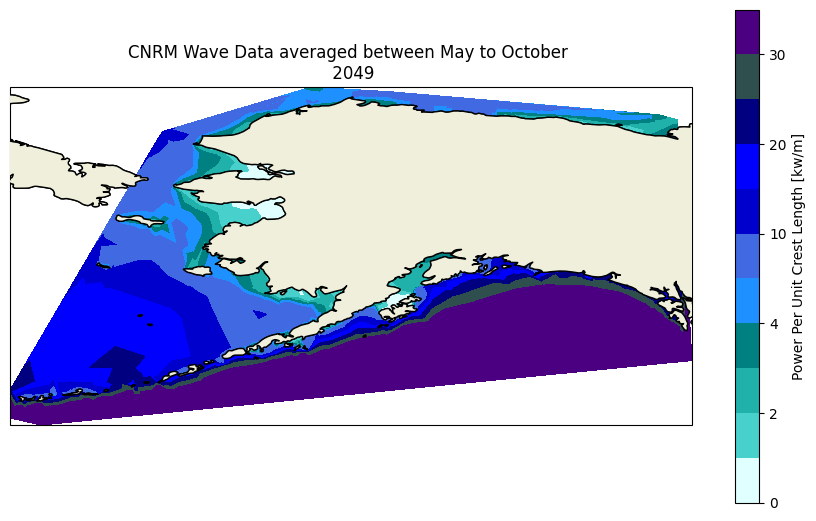

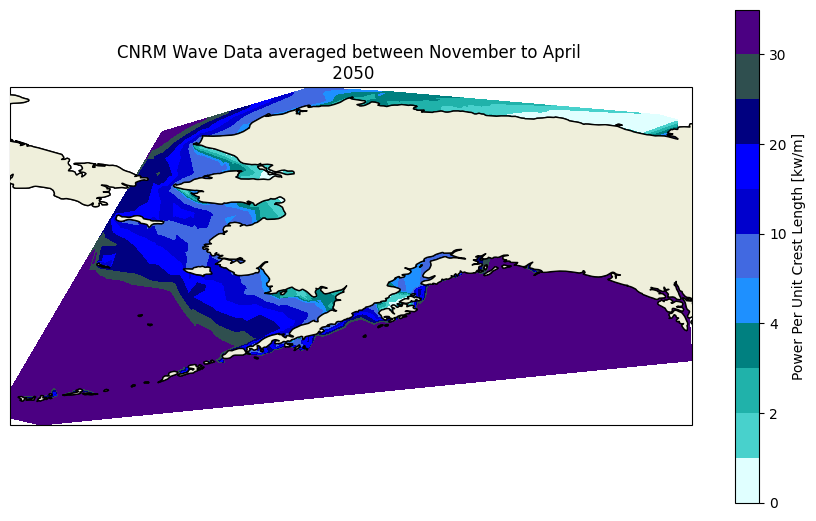

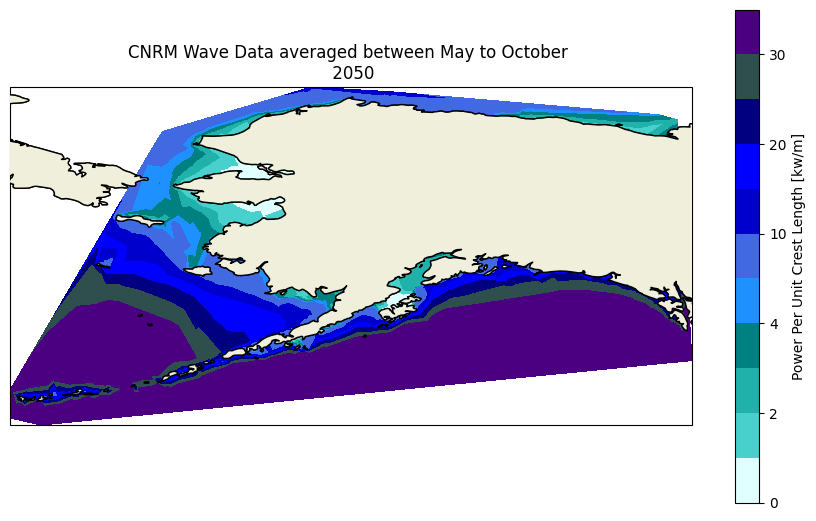

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import math

# Constants
roe = 997  # kg/m^3
g = 9.8  # m/s^2

# Calculate power per unit crest length
ds = ds.assign(j=roe * (g**2) * (0.85 / ds['fp']) * (ds['hs']**2) / (64 * math.pi))  # Watt/m
ds.j.attrs['units'] = 'watt/m'

# Remove infinite power values
ds = ds.where(ds.fp > 0)

# Define colors for the plot
colors = ['lightcyan', 'mediumturquoise', 'lightseagreen', 'teal', 'dodgerblue', 'royalblue', 'mediumblue', 'blue', 'navy', 'darkslategray', 'indigo']

# Define the model and plot directory
model = 'CNRM'
plot_directory = r'C:\Users\lache\Desktop\Cornell\Internship\Python Project\Plots' #CHANGE FOR WHERE PLOT FILE OUTPUT IS LOCATED 

if not os.path.exists(plot_directory):
    os.makedirs(plot_directory)

# Loop over each year from 2020 to 2050
for year in range(2020, 2051):
    # Select data for the current year
    ds_year = ds.sel(time=slice(f"{year}-01-01", f"{year}-12-31"))
    ds_year_month = ds_year.groupby('time.month').mean(dim='time', skipna=True)
    
    # Calculate ice and no-ice periods
    ds_year_ice = xr.concat([ds_year_month.isel(month=slice(0, 4)), ds_year_month.isel(month=slice(10, 12))], dim='month').mean(dim='month', skipna=True)
    ds_year_no_ice = ds_year_month.isel(month=slice(4, 10)).mean(dim='month', skipna=True)
    
    # Filter out NaN values for ice period
    valid_ice = ds_year_ice.dropna(dim='station', subset=['longitude', 'latitude', 'j'])

    # Only plot if there are valid data points
    if valid_ice.longitude.size > 0 and valid_ice.latitude.size > 0 and valid_ice.j.size > 0:
        # Plot for November to April (ice period)
        plt.figure(figsize=(11, 6.4))
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.add_feature(cfeature.LAND, edgecolor='black', zorder=10)

        contour_plot = plt.tricontourf(valid_ice.longitude, valid_ice.latitude, valid_ice.j / 1000,
                                       [0, 1, 2, 3, 4, 5, 10, 15, 20, 25, 30, max(valid_ice.j / 1000)],
                                       colors=colors, zorder=0)

        cbar = plt.colorbar(contour_plot)
        cbar.set_label("Power Per Unit Crest Length [kw/m]")

        ax.coastlines()
        plt.title(f'{model} Wave Data averaged between November to April \n {year}')
        plt.xticks(rotation=45)
        plt.yticks(rotation=45)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(base=2))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(base=2))
        plt.ylabel('Latitude [$^\circ$North]')
        plt.xlabel('Longitude [$^\circ$East]')

        # Save the plot
        plot_file_path = os.path.join(plot_directory, f'{model}_{year}_ice.png')
        plt.savefig(plot_file_path)
        plt.show()

    # Filter out NaN values for no-ice period
    valid_no_ice = ds_year_no_ice.dropna(dim='station', subset=['longitude', 'latitude', 'j'])

    # Only plot if there are valid data points
    if valid_no_ice.longitude.size > 0 and valid_no_ice.latitude.size > 0 and valid_no_ice.j.size > 0:
        # Plot for May to October (no-ice period)
        plt.figure(figsize=(11, 6.4))
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.add_feature(cfeature.LAND, edgecolor='black', zorder=10)

        contour_plot = plt.tricontourf(valid_no_ice.longitude, valid_no_ice.latitude, valid_no_ice.j / 1000,
                                       [0, 1, 2, 3, 4, 5, 10, 15, 20, 25, 30, max(valid_no_ice.j / 1000)],
                                       colors=colors, zorder=0)

        cbar = plt.colorbar(contour_plot)
        cbar.set_label("Power Per Unit Crest Length [kw/m]")

        ax.coastlines()
        plt.title(f'{model} Wave Data averaged between May to October \n {year}')
        plt.xticks(rotation=45)
        plt.yticks(rotation=45)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(base=2))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(base=2))
        plt.ylabel('Latitude [$^\circ$North]')
        plt.xlabel('Longitude [$^\circ$East]')

        # Save the plot
        plot_file_path = os.path.join(plot_directory, f'{model}_{year}_no_ice.png')
        plt.savefig(plot_file_path)
        plt.show()

## Difference

<>:98: SyntaxWarning: invalid escape sequence '\c'
<>:99: SyntaxWarning: invalid escape sequence '\c'
<>:98: SyntaxWarning: invalid escape sequence '\c'
<>:99: SyntaxWarning: invalid escape sequence '\c'
C:\Users\lache\AppData\Local\Temp\ipykernel_11796\1711040158.py:98: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel('Latitude [$^\circ$North]')
C:\Users\lache\AppData\Local\Temp\ipykernel_11796\1711040158.py:99: SyntaxWarning: invalid escape sequence '\c'
  plt.xlabel('Longitude [$^\circ$East]')


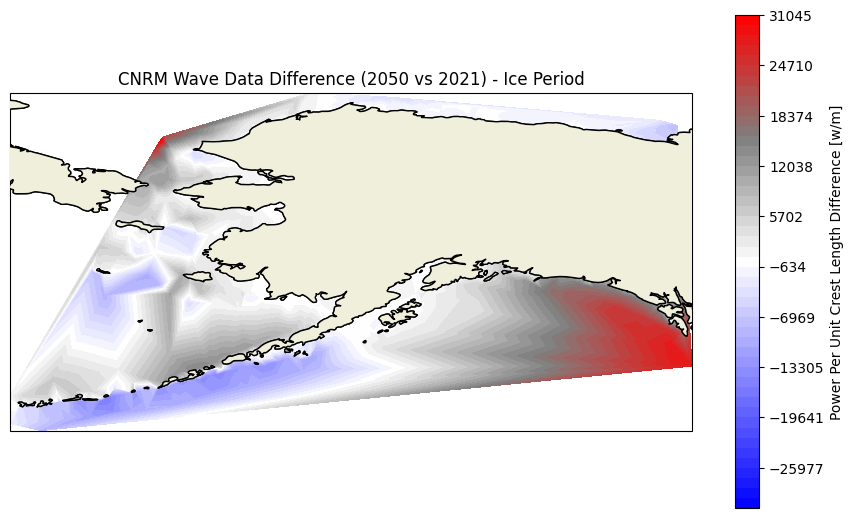

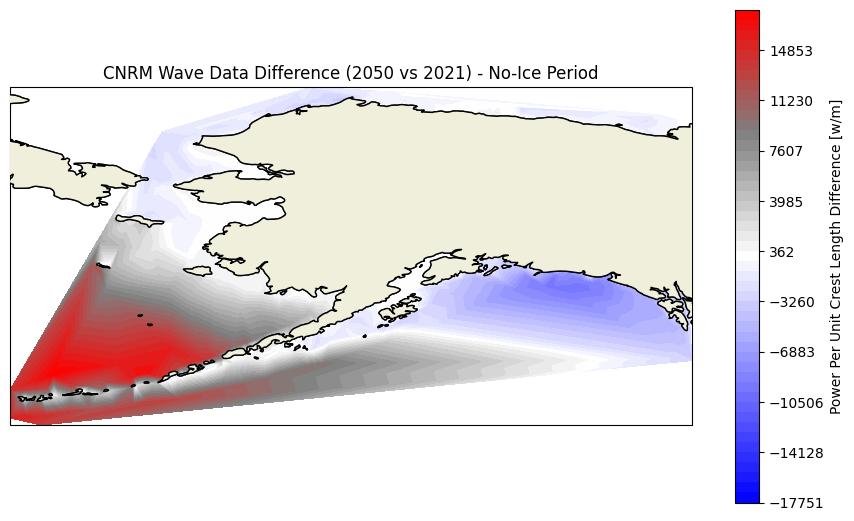

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import math
import matplotlib.colors as mcolors

# Constants
roe = 997  # kg/m^3
g = 9.8  # m/s^2

# Define the model and plot directory
model = 'CNRM'
directory = r'C:\Users\lache\Desktop\Cornell\Internship\Python Project' #CHANGE FOR WHERE PLOT FILE OUTPUT IS LOCATED 
file_name = 'WavePnts_CNRM_ak_4m_Fut.nc'
plot_directory = os.path.join(directory, 'Plots') #CHANGE FOR WHERE PLOT FILE OUTPUT IS LOCATED 

if not os.path.exists(plot_directory):
    os.makedirs(plot_directory)

# Load the dataset
import xarray as xr
file_path = os.path.join(directory, file_name)
ds = xr.open_dataset(file_path)

# Calculate power per unit crest length
ds = ds.assign(j=roe * (g**2) * (0.85 / ds['fp']) * (ds['hs']**2) / (64 * math.pi))  # Watt/m
ds.j.attrs['units'] = 'watt/m'

# Remove infinite power values
ds = ds.where(ds.fp > 0)

# Select 2021 data
ds_2021 = ds.sel(time=slice("2021-01-01", "2021-12-31"))
ds_2021_month = ds_2021.groupby('time.month').mean(dim='time', skipna=True)
ds_2021_ice = xr.concat([ds_2021_month.isel(month=slice(0, 4)), ds_2021_month.isel(month=slice(10, 12))], dim='month').mean(dim='month', skipna=True)
ds_2021_no_ice = ds_2021_month.isel(month=slice(4, 10)).mean(dim='month', skipna=True)

# Select 2050 data
ds_2050 = ds.sel(time=slice("2050-01-01", "2050-12-31"))
ds_2050_month = ds_2050.groupby('time.month').mean(dim='time', skipna=True)
ds_2050_ice = xr.concat([ds_2050_month.isel(month=slice(0, 4)), ds_2050_month.isel(month=slice(10, 12))], dim='month').mean(dim='month', skipna=True)
ds_2050_no_ice = ds_2050_month.isel(month=slice(4, 10)).mean(dim='month', skipna=True)

# Calculate differences
delta_ice = ds_2050_ice.j - ds_2021_ice.j
delta_no_ice = ds_2050_no_ice.j - ds_2021_no_ice.j

# Create masks for valid values
valid_mask_ice = ~np.isnan(delta_ice) & ~np.isnan(ds_2050_ice.longitude) & ~np.isnan(ds_2050_ice.latitude)
valid_longitude_ice = ds_2050_ice.longitude[valid_mask_ice]
valid_latitude_ice = ds_2050_ice.latitude[valid_mask_ice]
valid_delta_ice = delta_ice[valid_mask_ice]

valid_mask_no_ice = ~np.isnan(delta_no_ice) & ~np.isnan(ds_2050_no_ice.longitude) & ~np.isnan(ds_2050_no_ice.latitude)
valid_longitude_no_ice = ds_2050_no_ice.longitude[valid_mask_no_ice]
valid_latitude_no_ice = ds_2050_no_ice.latitude[valid_mask_no_ice]
valid_delta_no_ice = delta_no_ice[valid_mask_no_ice]

# Define a custom colormap
def custom_colormap():
    colors = [
        (0.0, "blue"),       # Blue for large negative values
        (0.5, "white"),      # White for zero
        (0.75, "gray"),      # Gray for small positive values
        (1.0, "red")         # Red for large positive values
    ]
    return mcolors.LinearSegmentedColormap.from_list("custom_colormap", colors)

# Define levels for symmetric scaling
def calculate_levels(delta_data):
    max_abs = np.nanmax(np.abs(delta_data))  # Get the largest magnitude (positive or negative)
    return np.linspace(-max_abs, max_abs, 50)  # Symmetric levels around zero

# Plotting function
def plot_difference(delta_data, title, file_name, valid_longitude, valid_latitude):
    if valid_longitude.size > 0 and valid_latitude.size > 0 and delta_data.size > 0:
        plt.figure(figsize=(11, 6.4))
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.add_feature(cfeature.LAND, edgecolor='black', zorder=10)

        levels = calculate_levels(delta_data)
        cmap = custom_colormap()

        contour_plot = plt.tricontourf(
            valid_longitude, valid_latitude, delta_data,
            levels=levels,
            cmap=cmap, zorder=0
        )

        cbar = plt.colorbar(contour_plot)
        cbar.set_label("Power Per Unit Crest Length Difference [w/m]")

        ax.coastlines()
        plt.title(title)
        plt.ylabel('Latitude [$^\circ$North]')
        plt.xlabel('Longitude [$^\circ$East]')
        plt.savefig(os.path.join(plot_directory, file_name))
        plt.show()

# Plot for ice season
plot_difference(
    valid_delta_ice,
    f'{model} Wave Data Difference (2050 vs 2021) - Ice Period',
    'difference_ice_2050_vs_2021_colormap.png',
    valid_longitude_ice,
    valid_latitude_ice
)

# Plot for no-ice season
plot_difference(
    valid_delta_no_ice,
    f'{model} Wave Data Difference (2050 vs 2021) - No-Ice Period',
    'difference_no_ice_2050_vs_2021_colormap.png',
    valid_longitude_no_ice,
    valid_latitude_no_ice
)             